This file is to train a MLP to approximate SGM (both FC and PSD)

PSD of SGM is in abs magnitude, 

but I want to train a MLP to approximate the PSD of SGM in log magnitude (in dB)

For FC, I ignore the diagonal elements and only care about the corr of the off-diagonal elements

In [1]:
from jin_utils import get_mypkg_path
import sys
mypkg = get_mypkg_path()
sys.path.append(mypkg)

from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, SGM_prior_bds, MIDRES_ROOT

In [2]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time
from tqdm import tqdm

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [6]:
from utils.reparam import ThetaTransform
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.mlp import SGMnet
from models.model_utils import MyDataset
from joblib import Parallel, delayed


In [7]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.distributions.multivariate_normal import MultivariateNormal


df_dtype = torch.float32
torch.set_default_dtype(df_dtype)

if False:
#if torch.cuda.is_available():
    print("use GPU for training")
    torch.set_default_device("cuda")
    torch.backends.cudnn.benchmark = True
    df_device = torch.device("cuda")
else:
    torch.set_default_device("cpu")
    df_device = torch.device("cpu")

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data, fn and paras

In [12]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [13]:
# load the dataset to get the freqs in real data (Apr 2, 2023)
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [14]:
# some constant parameters for this file
paras = edict()

# alpha, gei, gii, taue, tauG, taui, speed 
paras.names = ["alpha", "gei", "gii", "taue", "taug", "taui", "speed"]
paras.prior_bds = np.array([SGM_prior_bds[key] for key in paras.names])

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

sgmmodel = SGM(paras.C, paras.D, paras.freqs)

2025-02-28 21:39:05,019 - sgm.sgm - INFO - Num of ROI is 86.


In [15]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
paras_run.k = 0.15 # the parameter for reparameterization in logistic
paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

theta_trans_fn = ThetaTransform(prior_bds=paras.prior_bds, k=paras_run.k)

In [16]:
# the function to generate PSD with SGM
def get_psd(cur_sgm):
    input_sgm = {}
    for ix, key in enumerate(paras.names):
        input_sgm[key] = cur_sgm[ix]
    cur_PSD = sgmmodel.forward_psd(input_sgm)
    cur_PSD = cur_PSD[:68, :]
    return cur_PSD

def get_fc(cur_sgm):
    input_sgm = {}
    for ix, key in enumerate(paras.names):
        input_sgm[key] = cur_sgm[ix]
    cur_PSD = sgmmodel.forward_fc(input_sgm)
    cur_PSD = cur_PSD[:68, :68]
    return cur_PSD

## Generate simulated data

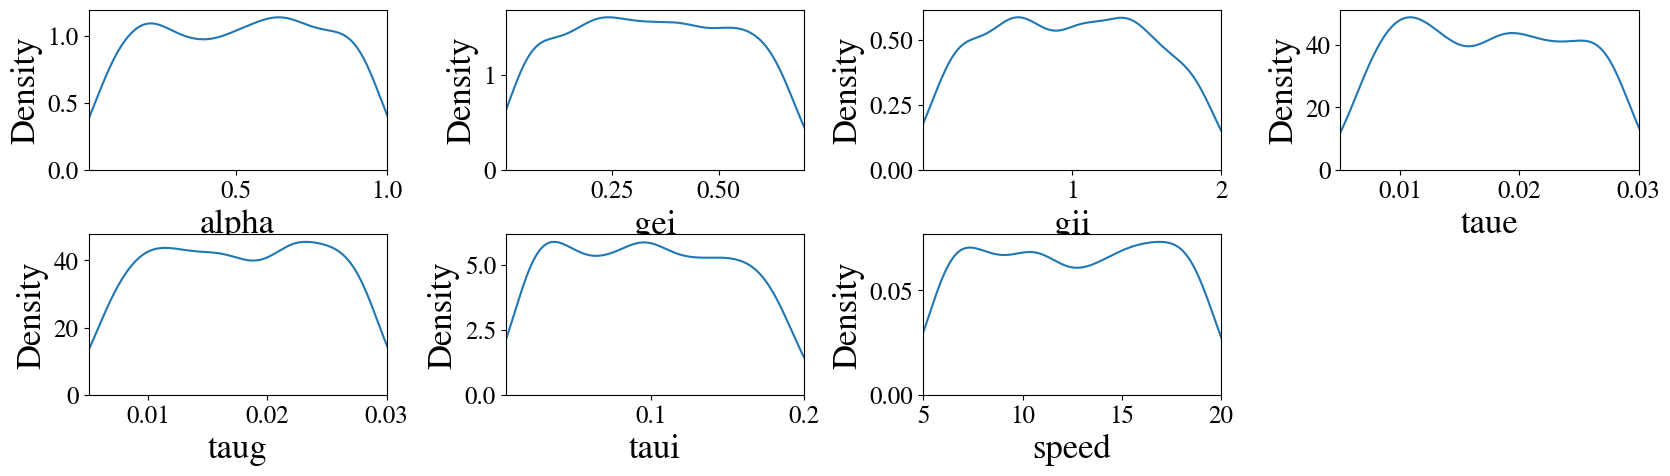

In [12]:
# show demo of generatingt simulation data (Speed is not a constant)
#check the reparameterization
sgm_params_raw = np.random.randn(1000, 7)*paras_run.sd
sgm_paramss = theta_trans_fn.raw2theta(sgm_params_raw)
    
plt.figure(figsize=[20, 5])
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    sns.kdeplot(sgm_paramss[:, ix])
    plt.xlim(paras.prior_bds[ix, :])
    plt.xlabel(paras.names[ix])

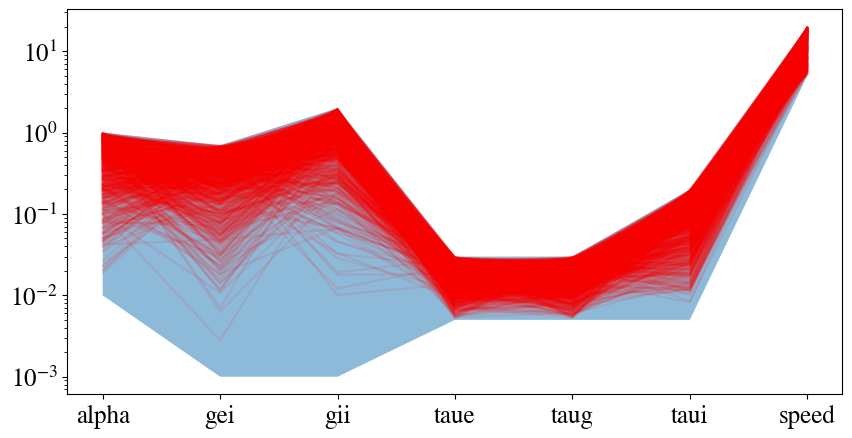

In [13]:
#check the reparameterization
plt.fill_between(np.arange(7), paras.prior_bds[:, 0], paras.prior_bds[:, 1], alpha=0.5)
plt.yscale("log")
for cur_sgm in sgm_paramss:
    plt.plot(np.arange(7), cur_sgm, color="red", alpha=0.1)
plt.xticks(np.arange(7), paras.names);
plt.show()

In [22]:
# demo of PSD
sgm_params_raw = np.random.randn(100, 7)*paras_run.sd
sgm_paramss = theta_trans_fn.raw2theta(sgm_params_raw)
    
n_jobs = 5
with Parallel(n_jobs=n_jobs) as parallel:
    PSDs = parallel(delayed(get_psd)(cur_sgm) for cur_sgm in tqdm(sgm_paramss))
    FCs = parallel(delayed(get_fc)(cur_sgm) for cur_sgm in tqdm(sgm_paramss))
PSDs = np.array(PSDs);
FCs = np.array(FCs);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.16it/s]


<Axes: >

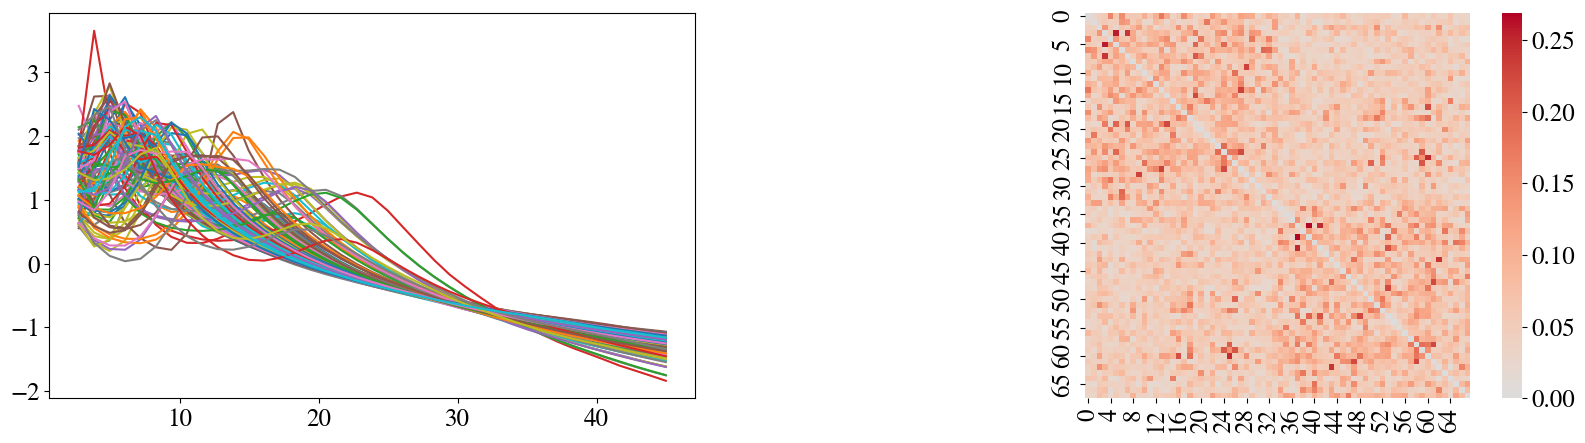

In [23]:
PSDs = 20*np.log10(PSDs)

plt.figure(figsize=[20, 5])
plt.subplot(1, 2, 1)
for ix in range(100):
    dat = PSDs[ix]
    dat_std = (dat-dat.mean(axis=-1, keepdims=True))/dat.std(axis=-1, keepdims=True)
    seq = dat_std.mean(axis=0)
    plt.plot(freqs, seq)

plt.subplot(1, 2, 2)
FC = FCs.mean(axis=0)
sns.heatmap(FC, square=True, cmap="coolwarm", center=0)

<Axes: >

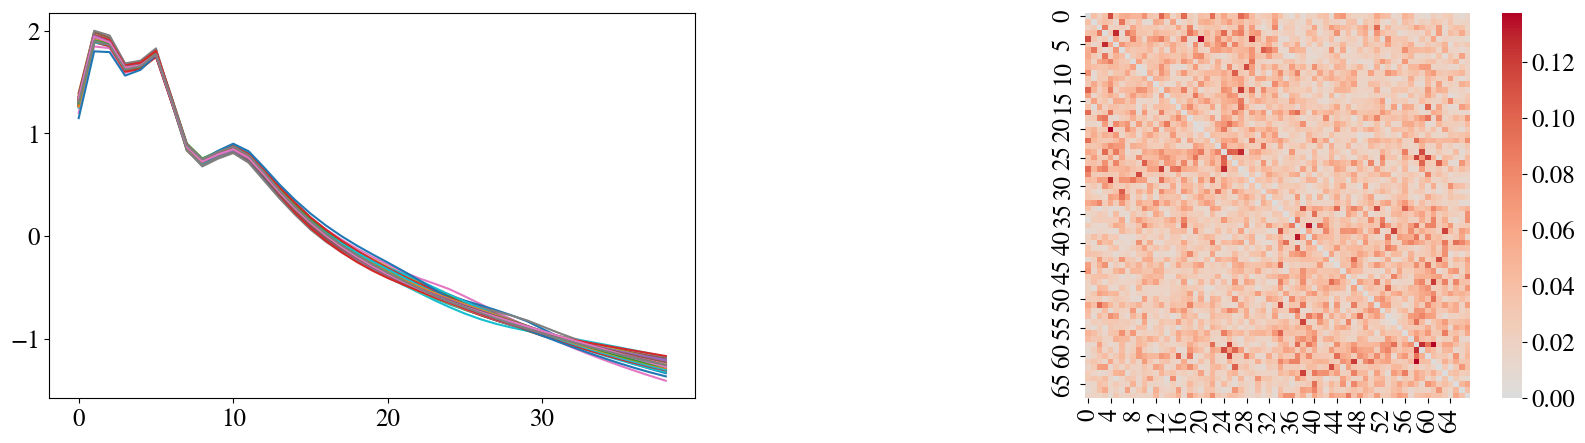

In [24]:
sub_ix = 1

plt.figure(figsize=[20, 5])
plt.subplot(1, 2, 1)
dat =PSDs[sub_ix]
dat_std = (dat-dat.mean(axis=-1, keepdims=True))/dat.std(axis=-1, keepdims=True)
for ix in range(68):
    plt.plot(dat_std[ix])

plt.subplot(1, 2, 2)
sns.heatmap(FCs[sub_ix], square=True, cmap="coolwarm", center=0)

In [ ]:
# Now generate the large dataset to train the model

#
# run `python_sccripts/gen_SGM_pairs.py`

## Train the model

In [35]:
from torch.utils.data import DataLoader
from models.loss import weighted_mse_loss, cos_simi_loss
from models.model_utils import MyDatasetwFC
from models.sgm_psd_net import SGMPSDNet

In [9]:
data_path = MIDRES_ROOT/"sgm_pairs_ntrain100000_ntest10000"
simu_sgm_data = load_pkl_folder2dict(data_path);

Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/FCs_test.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/PSDs.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/PSDs_test.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/freqs.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/sgm_paramss.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/sgm_paramss_test.pkl


In [ ]:

dataset = MyDatasetwFC(
    sgm_params = simu_sgm_data.sgm_paramss_test, 
    psds = simu_sgm_data.PSDs_test,
    fcs = simu_sgm_data.FCs_test)

In [36]:
net = SGMPSDNet(
    nroi=68, 
    nfreq=paras.freqs.shape[0], 
    nlayers=2, 
    mid_dim=128, 
    conv_channels=32,
    dropout_rate=0.5);

'total number of parameters: 1.37M'


In [30]:
sgm_params, psds, fcs = dataset[0]

input = torch.randn(10, 7)

tensor([[-0.1707,  1.2324,  1.1106, -0.6594, -0.1337, -0.6628,  1.1919],
        [ 0.7138,  0.7282, -0.9516,  0.0432,  0.5898,  0.5744, -0.0144],
        [ 1.1125, -1.0052,  0.3742,  0.8080, -0.5987,  0.5948,  0.8637],
        [ 3.0360, -0.5243, -0.3264,  1.8235, -1.2648,  2.0516,  0.8631],
        [-1.5489,  0.0267, -2.6145, -0.0314,  1.3500, -0.2761, -0.0388],
        [-0.2472,  1.3855,  0.9582,  1.3180,  0.0420,  0.4355, -0.0539],
        [-0.6407, -2.3013,  1.4729, -0.1238,  0.2915, -0.4689,  1.7036],
        [-2.9160,  0.7940,  0.9727,  0.7369, -0.9862, -0.8829,  0.5759],
        [ 0.0832, -0.5745, -0.2390, -1.3582, -0.8818, -0.7064, -0.3375],
        [ 0.4983, -0.6352,  0.7749, -2.0063, -0.7341,  0.6444,  0.4150]])

In [31]:
input.shape

torch.Size([10, 7])

In [34]:
net(input).shape

torch.Size([10, 68, 39])

In [14]:
save_path = RES_ROOT/f"sgmnet_{data_path.stem}"

paras_sgm_net = edict()
paras_sgm_net.batchsize = 512
paras_sgm_net.nepoch = 1000

paras_sgm_net.loss_out = 1
paras_sgm_net.lr_step = 200
paras_sgm_net.lr_gamma = 0.1
paras_sgm_net.lr = 1e-3
paras_sgm_net.weight_decay = 0

# We can use Pearsons R as loss, but let me try this later (on Apr 6, 2023)
#loss_fn = nn.MSELoss()
paras_sgm_net.loss_fn = weighted_mse_loss

In [ ]:
# the data loader for training and testing
#! 这里有点奇怪，当用cuda的时候，我的train_data生成的都是cpu，但是generator却必须是GPU，不然就报错
generator = torch.Generator(device=df_device)
train_data = MyDatasetwFC(
    sgm_params = simu_sgm_data.sgm_paramss, 
    psds = simu_sgm_data.PSDs,
    fcs = simu_sgm_data.FCs, 
    is_std_psd=True,
    is_std_fc=True, 
    dtype=df_dtype
)
train_data_loader = DataLoader(train_data, batch_size=paras_sgm_net.batchsize, shuffle=True, 
                               generator=generator)

test_data = MyDatasetwFC(
    sgm_params = simu_sgm_data.sgm_paramss_test, 
    psds = simu_sgm_data.PSDs_test,
    fcs = simu_sgm_data.FCs_test, 
    is_std_psd=True,
    is_std_fc=True, 
    dtype=df_dtype)
test_data_loader = DataLoader(test_data, batch_size=paras_sgm_net.batchsize, shuffle=False)

In [18]:
# the network
sgm_net = SGMnet(nroi=68, nfreq=len(paras.freqs)).to(df_dtype)
optimizer = torch.optim.Adam(sgm_net.parameters(), 
                             lr=paras_sgm_net.lr, 
                             weight_decay=paras_sgm_net.weight_decay)
scheduler = ExponentialLR(optimizer, gamma=paras_sgm_net.lr_gamma)

In [19]:
def evaluate(test_data_loader, net, loss_fn=None):
    if loss_fn is None:
        loss_fn = paras_sgm_net.loss_fn
    net.eval()
    losses = []
    with torch.no_grad():
        for X_batch, Y_batch in test_data_loader:
            X_batch, Y_batch = X_batch.to(df_device), Y_batch.to(df_device)
            Y_batch_pred = net(X_batch)
            loss = loss_fn(Y_batch, Y_batch_pred)
            losses.append(loss.item())
    net.train()
    return np.mean(losses)

In [21]:
# training
loss_cur = []
# mean losses
losses = []
losses_test = []

t0 = time.time()
for ie in range(paras_sgm_net.nepoch):
    for X_batch, Y_batch in train_data_loader:
        X_batch, Y_batch = X_batch.to(df_device), Y_batch.to(df_device)
        # Zero the gradients
        optimizer.zero_grad()
        
        Y_batch_est = sgm_net(X_batch)
        #print(Y_batch_est.sum(axis=(1, 2)))
        
        loss = paras_sgm_net.loss_fn(Y_batch, Y_batch_est)
        #print(loss)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        loss_cur.append(loss.item())
        
    if ie % paras_sgm_net.lr_step == (paras_sgm_net.lr_step-1):
        scheduler.step()
        cur_lr = scheduler.get_last_lr()[0]
        print(f"At epoch {ie+1}/{paras_sgm_net.nepoch}, the learning rate is {cur_lr:.5e}")
    if ie % paras_sgm_net.loss_out == (paras_sgm_net.loss_out-1):
    
        losses.append(np.mean(loss_cur))
        losses_test.append(evaluate(test_data_loader, sgm_net))
        print(f"At epoch {ie+1}/{paras_sgm_net.nepoch},"
              f"the losses are {losses[-1]:.5f} (train)"
              f" and {losses_test[-1]:.5f} (test). "
              f"The time used is {delta_time(t0):.3f}s. "
              )
        loss_cur = []
        t0 = time.time()
    

At epoch 1/1000,the losses are 0.87809 (train) and 0.86433 (test). The time used is 6.267s. 
At epoch 2/1000,the losses are 0.87716 (train) and 0.86139 (test). The time used is 6.902s. 
At epoch 3/1000,the losses are 0.87578 (train) and 0.85853 (test). The time used is 6.607s. 


KeyboardInterrupt: 

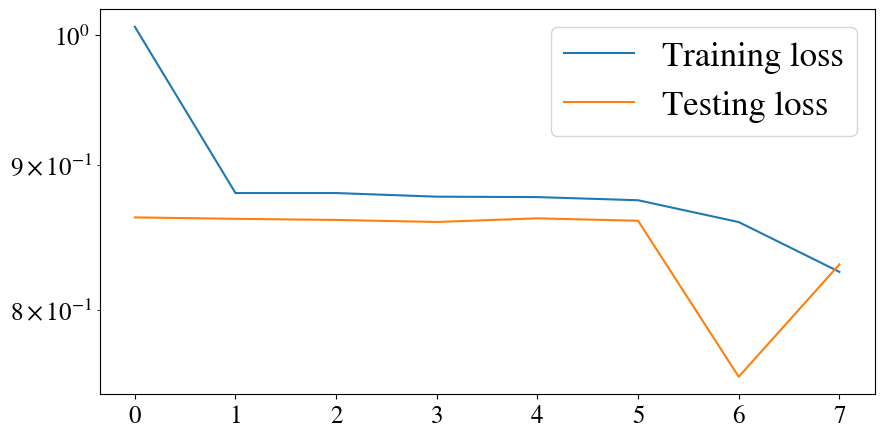

In [44]:
#check the loss
plt.plot(losses, label="Training loss")
plt.plot(losses_test, label="Testing loss")
plt.yscale("log")
plt.legend()

In [50]:
trained_model = edict()
trained_model.model = sgm_net.cpu()
trained_model.optimizer = optimizer
trained_model.paras = paras_sgm_net
trained_model.loss = losses
trained_model.loss_test = losses_test
trained_model.freqs = paras.freqs
save_pkl_dict2folder(save_path, trained_model, is_force=True)

/mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000
Create a folder /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/model.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/optimizer.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/paras.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/loss.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/loss_test.pkl
Save to /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain1

## Evaluate

In [42]:
def _get_psd(sgm_params):
    """get psd from sgm parameters based on sgmmodel
    args: 
        sgm_params: np.array, the sgm parameters 7 
    return:
        psd: np.array, the psd in dB and after standardization
    """
    if isinstance(sgm_params, torch.Tensor):
        sgm_params = sgm_params.cpu().numpy()
    psd = get_psd(sgm_params)
    psd_db = 20*np.log10(psd)
    psd_db_std = (psd_db-psd_db.mean(axis=-1, keepdims=True))/psd_db.std(axis=-1, keepdims=True)
    return psd_db_std

    

In [85]:
# if is_tmp is True, I use the model trained in this file
# otherwise, I use the model trained in another file
#! After MyDataset with is_std=True, PSD is in dB and standardize to have mean 0 and std 1 across freqs
is_tmp = False
if not is_tmp:
    # load old model
    #model_path = RES_ROOT/"SGM_net"
    #data_path = MIDRES_ROOT/"sgm_pairs_ntrain100000_ntest10000"

    model_path = RES_ROOT/"sgmnet_sgm_pairs_ntrain100000_ntest10000"
    data_path = MIDRES_ROOT/(model_path.stem.split("sgmnet_")[-1])
    simu_sgm_data = load_pkl_folder2dict(data_path);
    test_data = MyDataset(X=simu_sgm_data.sgm_paramss_test, Y=simu_sgm_data.PSDs_test, SGMfn=None, is_std=True, dtype=df_dtype)

    trained_model = load_pkl_folder2dict(model_path, excluding=["opt*"]);
else:
    model_path = save_path
    trained_model = load_pkl_folder2dict(model_path, excluding=["opt*"]);

Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/PSDs.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/PSDs_test.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/freqs.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/sgm_paramss.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../mid_results/sgm_pairs_ntrain100000_ntest10000/sgm_paramss_test.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/freqs.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/../results/sgmnet_sgm_pairs_ntrain100000_ntest10000/loss.pkl
Load file /mnt/nfs/rad/data/jianglab1/jin/MyResearch/TV-SGM_dev/mypkg/..

In [86]:
sgm_net.to(dtype=df_dtype);
sgm_net = trained_model.model
sgm_paramss, psd_gt= test_data["all"]
sgm_net.eval()
with torch.no_grad():
    psd_pred = sgm_net(sgm_paramss)

In [87]:
loss_fn = nn.MSELoss(reduction="none")
all_losses = loss_fn(psd_gt, psd_pred);
loss_subs = all_losses.mean(axis=(1, 2)).cpu().numpy();
all_losses.mean()

tensor(0.0017)

In [95]:
# show the index from the largest loss to the smallest loss
sorted_loss_subs = np.argsort(loss_subs)[::-1]
sorted_loss_subs[:100]


array([ 982, 2250, 7367, 2180, 1518, 6675, 4826, 5455, 5051, 2323, 3733,
       9787, 9883, 2836, 8962, 3406, 1927, 1128, 5078, 5030, 4882, 4794,
       3193, 7331, 9638,   88,    8, 2748, 6368, 9990, 8450, 3477,  391,
          0,  720, 8580, 4675, 7682, 5665, 4856, 6430,  778, 4652, 1344,
       4239, 7197, 2755, 4864, 6960, 1218,  909, 4389, 3109, 5164, 3153,
       3524, 2131, 5463,  587, 1032,  616, 7339, 3209, 3367, 4860, 9616,
        191, 3383, 1835, 6138, 7203, 1400, 1468,  682, 9574, 8909, 3182,
       2283, 7418, 1893, 7451, 8074, 1569, 4452, 3581, 9157, 5852, 1469,
       6633, 7839, 4340, 9643, 1416, 2795, 8575, 7236, 9007,  161, 6205,
       9036])

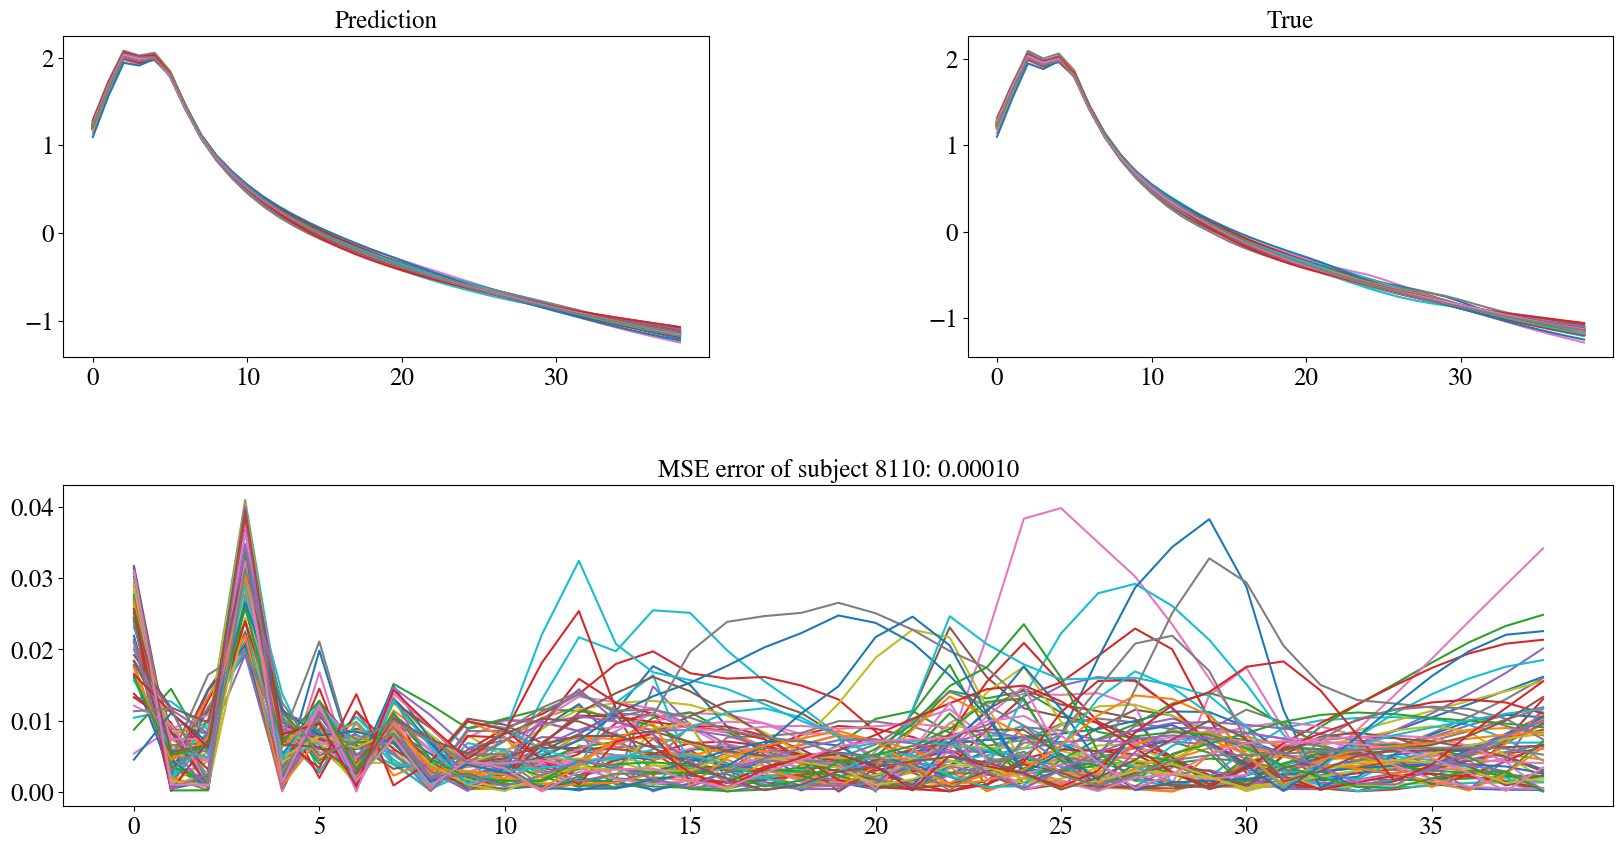

In [104]:
# check psd with specific subject
# check the x% quantile worst prediction
quantile = 1.00
idx = int(np.quantile(np.arange(len(loss_subs)), quantile))
sub_ix = sorted_loss_subs[idx]
cur_psd_pred = psd_pred[sub_ix]
cur_psd_gt = psd_gt[sub_ix]
plt.figure(figsize=[20, 10])
plt.subplot(221)
plt.title("Prediction")
for roi_ix in range(68):
    plt.plot(cur_psd_pred[roi_ix, :])
plt.subplot(222)
plt.title("True")
for roi_ix in range(68):
    plt.plot(cur_psd_gt[roi_ix, :])
plt.subplot(212)
plt.title(f"MSE error of subject {sub_ix}: {loss_subs[sub_ix]:.5f}")
for roi_ix in range(68):
    plt.plot(torch.abs(cur_psd_gt[roi_ix, :]- cur_psd_pred[roi_ix, :]))